In [32]:
import os
import gc
import warnings
import scipy.stats
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



In [8]:
base_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought'
data_dir = f'{base_dir}/data'
reservoir_data_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/DROM_CONUS_Analysis/Data/HydroShare'
output_dir = f'{data_dir}/results/lrr_output'

os.chdir(base_dir)


In [9]:
# The analysis is by each river basin (huc4)
# Specify basin huc4 here for following analysis
huc4 = '1709'

In [ ]:
# ---- Prepare geospatial files ---- #

nhd_data_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Drought_Cycle_Analysis/Data'
crs = 'EPSG:4326'
huc2_conus = [f'0{i}' if i<10 else f'{i}' for i in range(1, 19)]

# read reservoirs
df = pd.read_excel(f'{data_dir}/processed/reservoirs.xlsx', dtype={'huc4':str})
gdf_reservoirs = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
gdf_reservoirs.set_crs(crs, inplace=True, allow_override=True)

# read HUCs
huc2 = huc4[0:2]
gdb_file = f'{nhd_data_dir}/Raw/WBD/WBD_{huc2}_HU2_GDB.gdb'
gdf_huc2_all = gpd.read_file(gdb_file, layer='WBDHU2')
gdf_huc4_all = gpd.read_file(gdb_file, layer='WBDHU4')
gdf_huc6_all = gpd.read_file(gdb_file, layer='WBDHU6')
gdf_huc8_all = gpd.read_file(gdb_file, layer='WBDHU8')
gdf_huc10_all = gpd.read_file(gdb_file, layer='WBDHU10')

# set crs
gdf_huc2_all = gdf_huc2_all.set_crs(crs, inplace=False, allow_override=True)    # includes the huc2 region
gdf_huc4_all = gdf_huc4_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc4 subregions in this huc2 region
gdf_huc6_all = gdf_huc6_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc6 basins in this huc2 region
gdf_huc8_all = gdf_huc8_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc8 subbasins in this huc2 region
gdf_huc10_all = gdf_huc10_all.set_crs(crs, inplace=False, allow_override=True)    # includes all huc10 subbasins in this huc2 region

########## Prepare flow lines ##########

if huc2 == '03':    # multiple NHDP files for 03
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDPlusAttributes' for i in ['N','S','W']]
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDSnapshot/Hydrography' for i in ['N','S','W']]
elif huc2 == '10': 
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDPlusAttributes' for i in ['U','L']]
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDSnapshot/Hydrography' for i in ['U','L']]
else:
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}/NHDPlusAttributes']
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}/NHDSnapshot/Hydrography']

gdf_flow_list = []
for flow_attr_file, hydro_file in zip(flow_attr_file_list, hydro_file_list):
    gdf_fline_vaa = gpd.read_file(flow_attr_file, layer='PlusFlowlineVAA')
    gdf_fline = gpd.read_file(hydro_file, layer='NHDFlowline')

    # change COMID to ComID if the error exists
    if not 'ComID' in gdf_fline:
        gdf_fline.rename(columns={'COMID':'ComID'}, inplace=True)

    # change vaa file ComID to int
    to_int_var = ['ComID', 'StreamOrde', 'StreamCalc']
    gdf_fline_vaa[to_int_var] = gdf_fline_vaa[to_int_var].astype(int)

    # merge this two gdfs
    to_merge_vars = ['ComID', 'StreamOrde', 'StreamCalc', 'FromNode', 'ToNode']
    gdf_flow = gdf_fline.merge(gdf_fline_vaa[to_merge_vars], how='inner', on='ComID')
    
    gdf_flow_list.append(gdf_flow)

gdf_flow = pd.concat(gdf_flow_list)

# set crs
gdf_flow = gdf_flow.set_crs(crs, inplace=True, allow_override=True)

# subset to the target huc4
gdf_flow_huc4 = gdf_flow.sjoin(gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4], how='inner', predicate='intersects')

########## End Prepare flow lines ##########


# Calculate Water Supply Drought Risk

In [66]:
"""
Define functions
"""

"""
drought_index = deficit_volume[event_E] / baseline_volume
baseline_volume = mean of all deficit volumes in the entire simulation period
drought_risk = sum: drought_index * prob(drought event)
prob(drought event) = count(drought event) / total count
"""

def cal_baseline_volume(deficit_array_entire_period, threshold=0.00001):
    """
    Calculate the baseline deficit volume.
        here, I use the average deficit volume of each drought event in the entire simulation period
        a drought event is defined as a period of consecutive days with deficit volume > 0

    Args:
        deficit_array_entire_period: numpy array
            daily deficit volume of each grid cell in the entire simulation period

    Returns:
        baseline_volume: float
            the average deficit volume of each drought event in the entire simulation period
    """

    # find drought events, by splitting the deficit_array_entire_period by the negative values
    drought_events = np.split(deficit_array_entire_period, np.where(deficit_array_entire_period < threshold)[0])    # list of subarrays
    drought_events = [event for event in drought_events if len(event) > 1]
    drought_events = [event[1:] for event in drought_events]    # remove the first element of each subarray, which is the negative value

    # if there is only one drought event, it means that the entire period is a drought event
    # TODO: refine this
    if len(drought_events) == 1:
        print('The entire period is a drought event.')
        return np.sum(drought_events[0])
    
    if deficit_array_entire_period[-1] > 0:
        drought_events = drought_events[:-1]    # remove the last subarray, which can be an incomplete drought event


    # calculate the average deficit volume of each drought event in the entire simulation period
    baseline_volume = np.mean([np.sum(event) for event in drought_events])

    return baseline_volume

def cal_drought_risk(deficit_array, baseline_deficit, threshold=0.00001):
    """
    Calculate drought risk over a period of time, e.g., every 15-year moving window.

    Args:
        deficit_array: numpy array
            daily deficit volume of each grid cell in the given period of time
        baseline_deficit: float

    Returns:
        drought_risk: float
    """

    if np.all(deficit_array < threshold):
        return 0
    
    # find drought events, by splitting the deficit_array by the negative values
    # TODO: wrap this into a function
    drought_events = np.split(deficit_array, np.where(deficit_array < threshold)[0])    # list of subarrays
    drought_events = [event for event in drought_events if len(event) > 1]
    drought_events = [event[1:] for event in drought_events]    # remove the first element of each subarray, which is the negative value

    # if there is only one drought event, it means that the entire period is a drought event
    # TODO: refine this
    if len(drought_events) == 1:
        return np.sum(drought_events[0]) / baseline_deficit
    
    if deficit_array[-1] > 0:
        drought_events = drought_events[:-1]    # remove the last subarray, which can be an incomplete drought event

    if len(drought_events) == 0:
        return 0

    # calculate drought risk
    drought_index = [np.sum(event) / baseline_deficit for event in drought_events]
    prob_drought_event = 1 / len(drought_events)    # TODO: replace with the actual probability of each event
    drought_risk = np.sum([drought_index[i] * prob_drought_event for i in range(len(drought_index))])

    return drought_risk

    
# test
deficit_array_entire_period = np.array([1, -1, -2, 1, 2, 3, -1, -2, -3, -4, 1, 2, 3, -1, -2, -3, 7, 7, 4, -1])
baseline_deficit = cal_baseline_volume(deficit_array_entire_period)
print(baseline_deficit)

# # test
# deficit_array = np.array([1, -1, -2, 1, 2, 3, -1, -2, -3, -4, 1, 2, 3, -1, -2, -3, 7, 7, 4, -1, 1, 2, 100, -5])
# drought_risk = cal_drought_risk(deficit_array, baseline_deficit)
# print(drought_risk)

10.0


In [67]:
threshold=0.00001
deficit_array = deficit_series.values
drought_events = np.split(deficit_array_entire_period, np.where(deficit_array_entire_period < threshold)[0])    # list of subarrays
drought_events = [event for event in drought_events if len(event) > 1]
drought_events = [event[1:] for event in drought_events]    # remove the first element of each subarray, which is the negative value
cal_baseline_volume(deficit_array_entire_period, threshold=0.00001)

10.0

In [70]:
"""
Calculate water deficit drought risk for each grid cell in a moving window
    On a monthly basis
"""

# Convert warnings to exceptions
warnings.filterwarnings('error')

huc4_list = ['0301', '0305', '0306', '0313', '0315', '0505', '0507', '0509', '0511', '0512', '0513', '0601', '0602', '0603', '0701', '0702', '0708', '0710', '0714', '0902', '0804', '1003', '1008', '1012', '1018', '1025', '1026', '1027', '1028', '1029', '1101', '1102', '1107', '1111', '1114', '1201', '1202', '1203', '1210', '1302', '1307', '1401', '1402', '1404', '1506', '1602', '1703', '1704', '1705', '1709', '1711', '1802', '1803', '1804']

for huc4 in huc4_list:
    print(f'---- Processing {huc4} ----')
    # read simulation results
    try:
        ds = xr.load_dataset(f'{output_dir}/{huc4}/model_states_{huc4}.nc')
    except FileNotFoundError:
        print(f'No simulation results for {huc4}')
        continue

    # Omit the first 2 years of spinup
    spinup_start = '1988-01-01'
    spinup_end = '1990-01-01'
    spinup_len = (pd.to_datetime(spinup_end) - pd.to_datetime(spinup_start)).days
    # skip the first 2 years of spinup
    ds = ds.isel(time=slice(spinup_len, None))

    # get the grid indices that locate in the huc4: flow_direction != -1
    huc4_lat_lon_tup = np.where(ds['flow_direction'] != -1)    # (lat_ind_array, lon_ind_array) pair

    # loop through each grid cell & calculate moving-window reliability, resilience, vulnerability for each grid cell
    window_size_year = 15    # 10 years
    window_size = 12 * window_size_year    # 10 years -> 3650 days
    drought_risk_dict = {f'{i}_{j}': None for i, j in zip(huc4_lat_lon_tup[0], huc4_lat_lon_tup[1])}    # key: lat_lon, value: drought risk series

    for i, (lat_ind, lon_ind) in enumerate(zip(huc4_lat_lon_tup[0], huc4_lat_lon_tup[1])):
        if i % 20 == 0:
            print(f'Processing {i}th grid cell...')

        # get water deficit time series over the entire simulation period
        deficit_array_entire_period = ds['water_deficit'].isel(lat=lat_ind, lon=lon_ind).values
        # if all values are below 0.000001, then skip this grid cell - no drought risk
        if np.all(deficit_array_entire_period < 0.000001):
            continue
        
        # ELSE, calculate the moving-window drought risk
        # convert to pandas series
        deficit_series = pd.Series(deficit_array_entire_period, index=pd.to_datetime(ds['time'].values))
        
        # convert to monthly
        deficit_series = deficit_series.resample('M').sum()

        # get the baseline deficit volume
        try: 
            baseline_deficit = cal_baseline_volume(deficit_series.values)
        except RuntimeWarning:
            print(f'RuntimeWarning: {i}: {lat_ind}_{lon_ind}')
            import sys
            sys.exit()

        # Calculate moving-window drought risk
        drought_risk_series = deficit_series.rolling(window_size, center=True).apply(cal_drought_risk, args=(baseline_deficit,), raw=True)

        # append to dictionary
        drought_risk_dict[f'{lat_ind}_{lon_ind}'] = drought_risk_series

    # convert to dataframe
    df_risk_huc4 = pd.DataFrame(drought_risk_dict)
    df_risk_huc4.index.name = 'time'

    # save to file
    df_risk_huc4.to_csv(f'data/results/basin_drought_risk/{huc4}.csv')

    # clear memory
    del ds, df_risk_huc4
    gc.collect()



---- Processing 0301 ----
Processing 0th grid cell...
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
Processing 20th grid cell...
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
The entire period is a drought event.
Processing 40th grid cell...
The entire period is a drought event.
The entire per

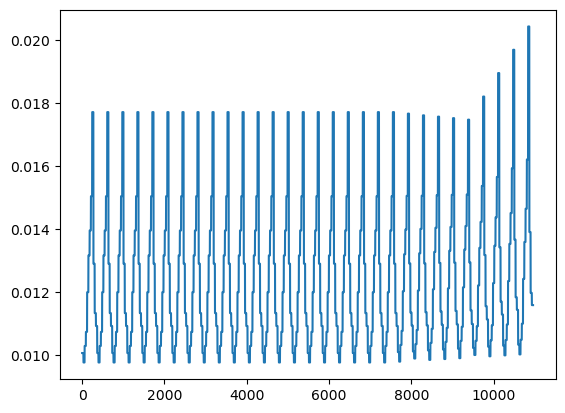

In [ ]:
df_risk_huc4.to_csv(f'data/results/basin_drought_risk/{huc4}.csv')

# Sustainability Index

In [ ]:
# ---- Define reliability, resilience, vulnerability ---- #

def cal_reliability(deficit_array, threshold=0.0001):
    """
    Calculate reliability of water deficit time series for a given grid.
    
    threshold: the threshold of water deficit, above which to be considered as a deficit
    """

    n_deficit = deficit_array[deficit_array > threshold].size

    reliability = 1 - n_deficit / deficit_array.size

    return(reliability)

def cal_resilience(deficit_array, threshold=0.0001):
    """
    Calculate resilience of water deficit time series for a given grid.
        Resilience: number of times a non-deficit day follows a deficit day / number of deficit days
    
    threshold: the threshold of water deficit, above which to be considered as a deficit
    """

    n_deficit = deficit_array[deficit_array > threshold].size
    if n_deficit == 0:    # if there is no deficit, no resilience
        return np.nan
    
    n_resilience = 0

    for i in range(deficit_array.size - 1):
        if deficit_array[i] > threshold and deficit_array[i + 1] <= threshold:
            n_resilience += 1

    resilience = n_resilience / n_deficit
    
    return(resilience)

def cal_vulnerability(deficit_array, threshold=0.0001):
    """
    Calculate vulnerability of water deficit time series for a given grid.
        Vulnerability: sum of deficit amount / number of deficit days
    
    threshold: the threshold of water deficit, above which to be considered as a deficit
    """

    n_deficit = deficit_array[deficit_array > threshold].size
    if n_deficit == 0:    # if there is no deficit, no vulnerability
        return np.nan

    vulnuerability = np.sum(deficit_array[deficit_array > threshold]) / n_deficit

    return(vulnuerability)



## Moving-window sustainability index & Visualization

In [ ]:
# read simulation results
ds = xr.load_dataset(f'{output_dir}/{huc4}/model_states_{huc4}.nc')

# Omit the first 2 years of spinup
spinup_start = '1988-01-01'
spinup_end = '1990-01-01'
spinup_len = (pd.to_datetime(spinup_end) - pd.to_datetime(spinup_start)).days
# skip the first 2 years of spinup
ds = ds.isel(time=slice(spinup_len, None))

# get the grid indices that locate in the huc4: flow_direction != -1
huc4_lat_lon_tup = np.where(ds['flow_direction'] != -1)    # (lat_ind_array, lon_ind_array) pair

# loop through each grid cell & calculate moving-window reliability, resilience, vulnerability for each grid cell
window_size_year = 15    # 10 years
window_size = 365 * window_size_year    # 10 years -> 3650 days
reliability_list = []    # list of reliability Series (moving-window) for each grid cell
resilience_list = []    # list of resilience Series (moving-window) for each grid cell
vulnerability_list = []    # list of vulnerability Series (moving-window) for each grid cell

for lat_ind, lon_ind in zip(huc4_lat_lon_tup[0], huc4_lat_lon_tup[1]):
    # get water deficit time series
    deficit_array = ds['water_deficit'].isel(lat=lat_ind, lon=lon_ind).values
    # convert to pandas series
    deficit_series = pd.Series(deficit_array, index=ds['time'].values)
    # convert index to datetime
    deficit_series.index = pd.to_datetime(deficit_series.index)
    
    # Calculate moving-window reliability, resilience, vulnerability
    reliability_rolling_series = deficit_series.rolling(window_size, center=True).apply(cal_reliability, raw=True)
    resilience_rolling_series = deficit_series.rolling(window_size, center=True).apply(cal_resilience, raw=True)

    # append to list
    reliability_list.append(reliability_rolling_series)
    resilience_list.append(resilience_rolling_series)



In [ ]:
# ---- Temply save the results to csv ---- #

df_reliability = pd.concat(reliability_list, axis=1)
df_resilience = pd.concat(resilience_list, axis=1)

# save to csv
df_reliability.to_csv(f'{output_dir}/{huc4}/reliability_{huc4}_{window_size_year}.csv')
df_resilience.to_csv(f'{output_dir}/{huc4}/resilience_{huc4}_{window_size_year}.csv')

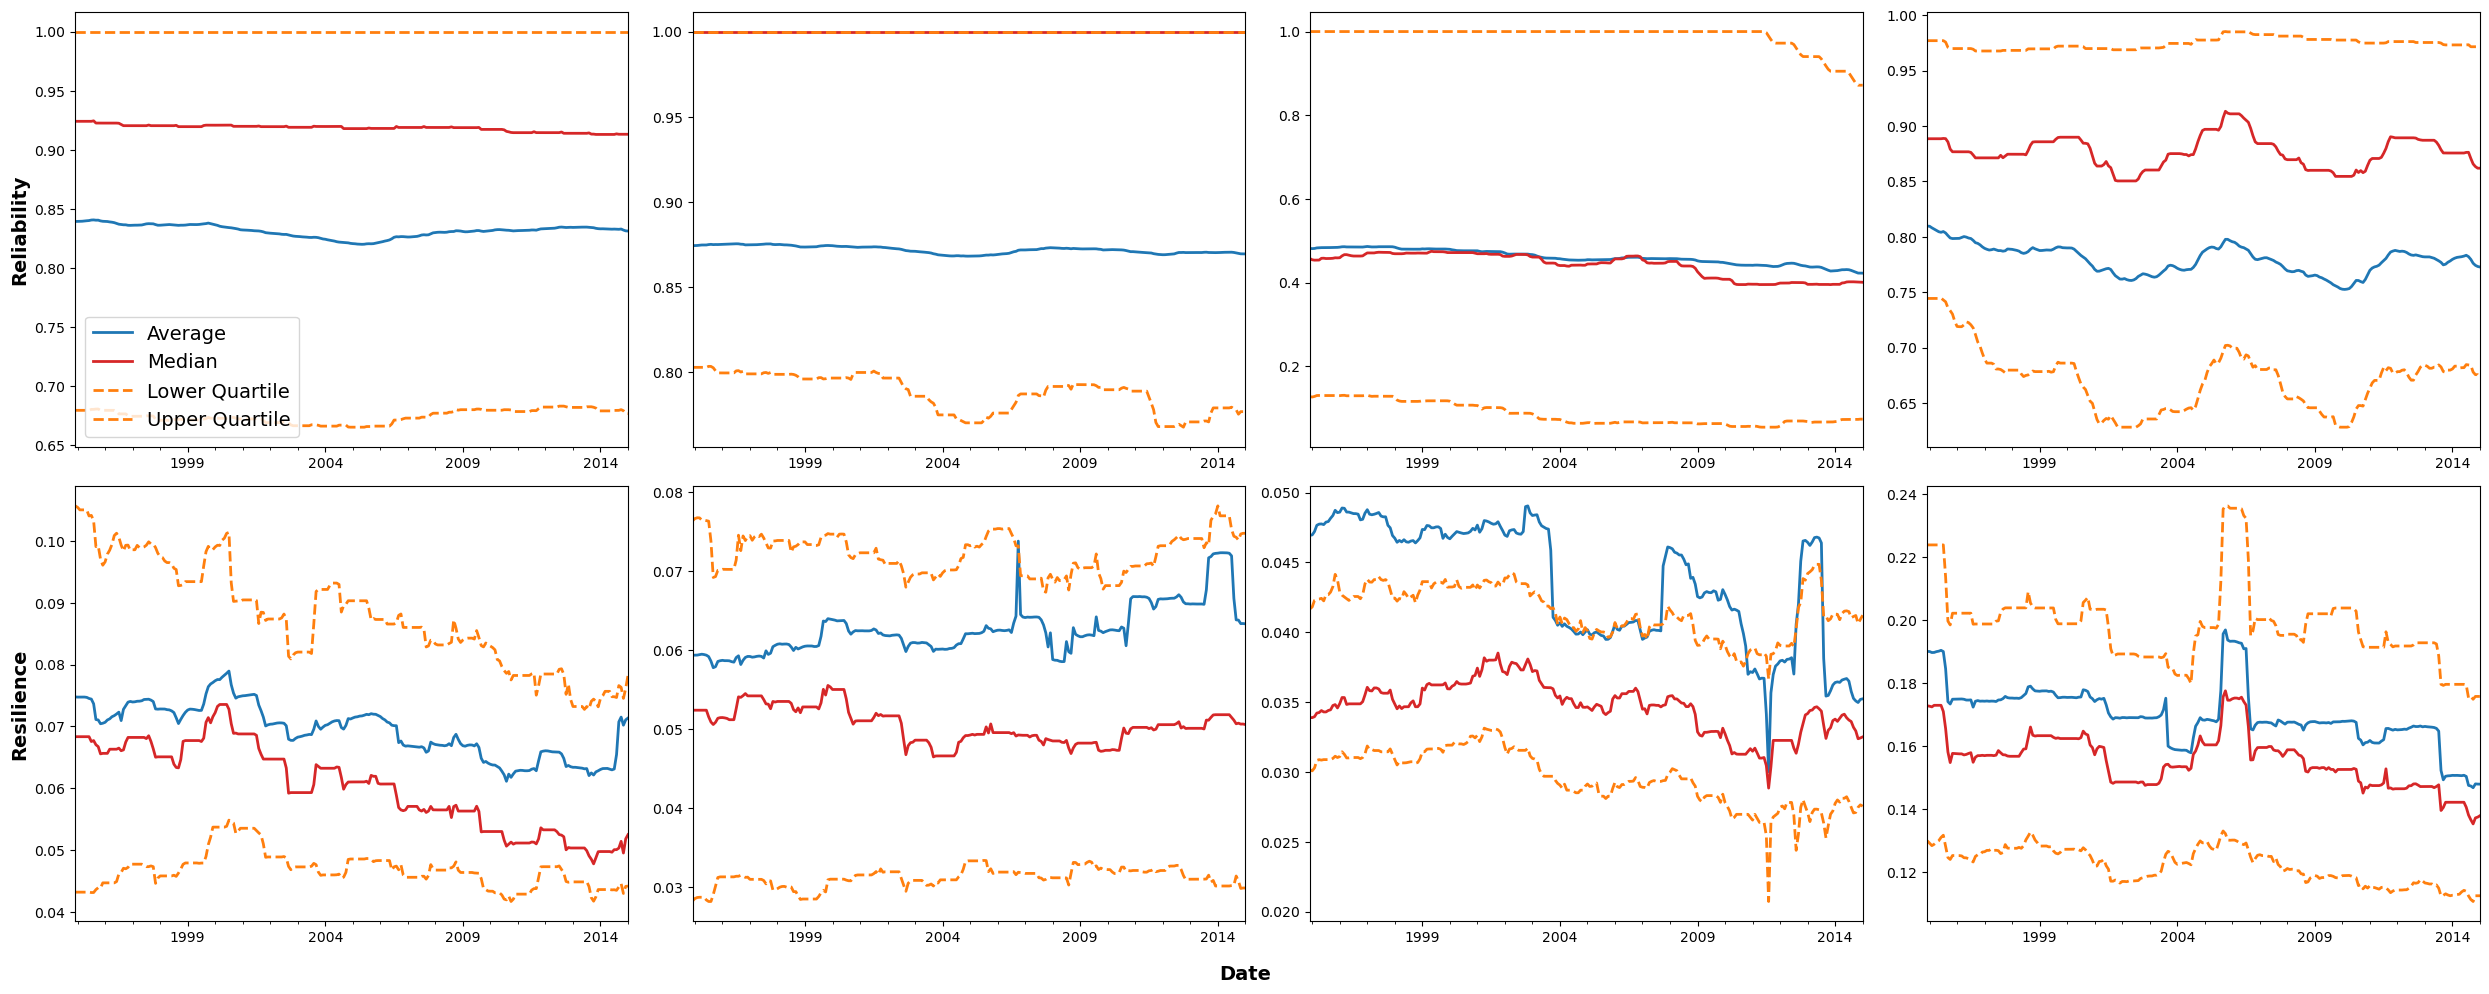

In [ ]:
# ---- Plot reliability, resilience, vulnerability time series for all basins in one plot ---- #

huc4_list = ['1709', '1705', '1804', '1203']
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25, 10), sharex=False, sharey=False)

for i, huc4 in enumerate(huc4_list):

    # Plot for reliability
    df_reliability = pd.read_csv(f'{output_dir}/{huc4}/reliability_{huc4}.csv', index_col=0, parse_dates=True)
    df_resilience = pd.read_csv(f'{output_dir}/{huc4}/resilience_{huc4}.csv', index_col=0, parse_dates=True)

    df_reliability_month = df_reliability.resample('MS').mean()
    # df_reliability_month.plot(ax=ax[0, i], color='whitesmoke', legend=False)
    # plot mean & median
    df_reliability_month.mean(axis=1).plot(ax=ax[0, i], color='tab:blue', linewidth=2, label='Average')
    df_reliability_month.median(axis=1).plot(ax=ax[0, i], color='tab:red', linewidth=2, label='Median')
    # plot 25% & 75% quantile
    df_reliability_month.quantile(0.25, axis=1).plot(ax=ax[0, i], color='tab:orange', linewidth=2, linestyle='--', label='Lower Quartile')
    df_reliability_month.quantile(0.75, axis=1).plot(ax=ax[0, i], color='tab:orange', linewidth=2, linestyle='--', label='Upper Quartile')

    # Plot for resilience
    df_resilience_month = df_resilience.resample('MS').mean()
    # df_resilience_month.plot(ax=ax[1, i], color='whitesmoke', legend=False)
    # plot mean & median
    df_resilience_month.mean(axis=1).plot(ax=ax[1, i], color='tab:blue', linewidth=2, label='Average')
    df_resilience_month.median(axis=1).plot(ax=ax[1, i], color='tab:red', linewidth=2, label='Median')
    # plot 25% & 75% quantile
    df_resilience_month.quantile(0.25, axis=1).plot(ax=ax[1, i], color='tab:orange', linewidth=2, linestyle='--', label='25th Percentile')
    df_resilience_month.quantile(0.75, axis=1).plot(ax=ax[1, i], color='tab:orange', linewidth=2, linestyle='--', label='75th Percentile')

    # # Plot drought events
    # df_pdsi = pd.read_csv(f'{data_dir}/processed/LRR/input/pdsi_{huc4}.csv', index_col=0, parse_dates=True)
    # # find drought periods: PDSI < -1
    # drought_periods = []
    # for i in range(df_pdsi.size - 1):
    #     if df_pdsi.iloc[i, 0] < 0 and df_pdsi.iloc[i+1, 0] < -1:
    #         drought_periods.append(df_pdsi.index[i])

    # # plot drought periods
    # for drought_period in drought_periods:
    #     if drought_period < df_reliability_month.dropna().index[0] or drought_period > df_reliability_month.dropna().index[-1]:
    #         continue
    #     ax[0, i].axvspan(drought_period, drought_period + pd.DateOffset(months=1), color='lightgray', alpha=0.5)
    #     ax[1, i].axvspan(drought_period, drought_period + pd.DateOffset(months=1), color='lightgray', alpha=0.5)

    ax[0, i].set_xlim([df_reliability_month.dropna().index[0], df_reliability_month.dropna().index[-1]])
    ax[1, i].set_xlim([df_reliability_month.dropna().index[0], df_reliability_month.dropna().index[-1]])
    

ax[0,0].legend(loc='lower left', fontsize=14)

# ax[1,0].set_ylim([0, 0.4])
# ax[1,1].set_xlim([df_reliability_month.dropna().index[0], df_reliability_month.dropna().index[-1]])

ax[0,0].set_ylabel('Reliability', fontsize=14, fontweight='bold')
ax[1,0].set_ylabel('Resilience', fontsize=14, fontweight='bold')

fig.supxlabel('Date', fontsize=14, fontweight='bold')

plt.tight_layout()

plt.savefig(f'{output_dir}/reliability_resilience_nosharexy.jpg', dpi=300)
plt.show()

### Find drought periods for each basin

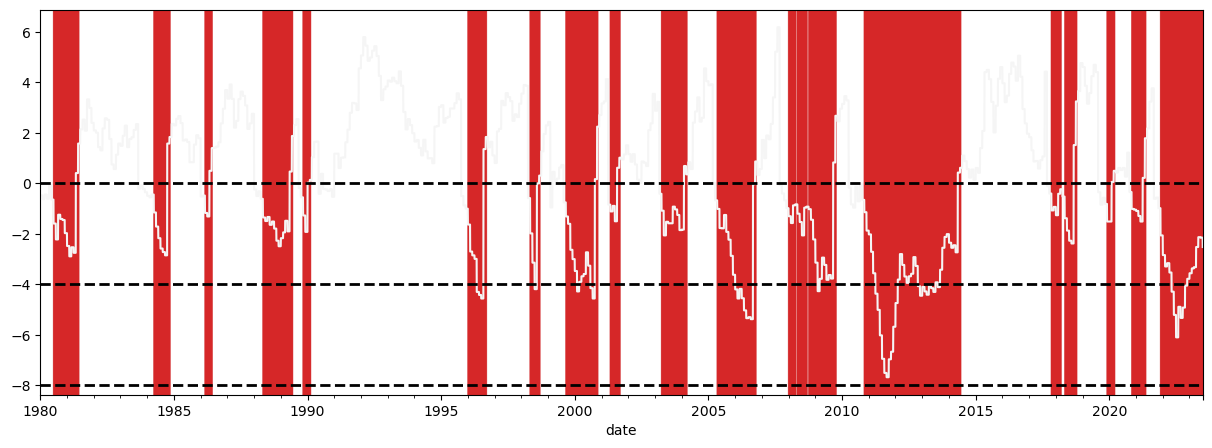

In [ ]:
# ---- Find drought periods using PDSI ---- #

huc4 = '1203'
# read PDSI
df_pdsi = pd.read_csv(f'{data_dir}/processed/LRR/input/pdsi_{huc4}.csv', index_col=0, parse_dates=True)

# find drought periods: PDSI < 0
drought_periods = []
for i in range(df_pdsi.size - 1):
    if df_pdsi.iloc[i, 0] < 0 and df_pdsi.iloc[i+1, 0] < -1:
        drought_periods.append(df_pdsi.index[i])

# ---- Plot PDSI & drought periods ---- #
fig, ax = plt.subplots(figsize=(15, 5))

df_pdsi.plot(ax=ax, color='whitesmoke', legend=False)
ax.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax.axhline(y=-4, color='black', linestyle='--', linewidth=2)
ax.axhline(y=-8, color='black', linestyle='--', linewidth=2)

for drought_period in drought_periods:
    ax.axvspan(drought_period, drought_period + pd.DateOffset(months=1), color='tab:red', alpha=0.5)

plt.show()


In [ ]:
drought_periods

[Timestamp('1985-01-01 00:00:00'),
 Timestamp('1985-01-02 00:00:00'),
 Timestamp('1985-01-03 00:00:00'),
 Timestamp('1985-01-04 00:00:00'),
 Timestamp('1985-01-05 00:00:00'),
 Timestamp('1985-01-06 00:00:00'),
 Timestamp('1985-01-07 00:00:00'),
 Timestamp('1985-01-08 00:00:00'),
 Timestamp('1985-01-09 00:00:00'),
 Timestamp('1985-01-10 00:00:00'),
 Timestamp('1985-01-11 00:00:00'),
 Timestamp('1985-01-12 00:00:00'),
 Timestamp('1985-01-13 00:00:00'),
 Timestamp('1985-01-14 00:00:00'),
 Timestamp('1985-01-15 00:00:00'),
 Timestamp('1985-01-16 00:00:00'),
 Timestamp('1985-01-17 00:00:00'),
 Timestamp('1985-01-18 00:00:00'),
 Timestamp('1985-01-19 00:00:00'),
 Timestamp('1985-01-20 00:00:00'),
 Timestamp('1985-01-21 00:00:00'),
 Timestamp('1985-01-22 00:00:00'),
 Timestamp('1985-01-23 00:00:00'),
 Timestamp('1985-01-24 00:00:00'),
 Timestamp('1985-01-25 00:00:00'),
 Timestamp('1985-01-26 00:00:00'),
 Timestamp('1985-01-27 00:00:00'),
 Timestamp('1985-01-28 00:00:00'),
 Timestamp('1985-01-

In [ ]:
df_reliability_pivoted

index,1990-01-01,1990-02-01,1990-03-01,1990-04-01,1990-05-01,1990-06-01,1990-07-01,1990-08-01,1990-09-01,1990-10-01,...,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
grid,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
flights = sns.load_dataset("flights")
flights

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


/opt/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/var/folders/16/txrkznhx25n2cjbvr4p2vqgh0000gn/T/ipykernel_21440/3789403890.py:9: RuntimeWarning: Mean of empty slice
  ax.plot(date_range, np.nanmean(reliability_array, axis=0), label='Mean', color='tab:orange')
/opt/miniconda3/envs/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


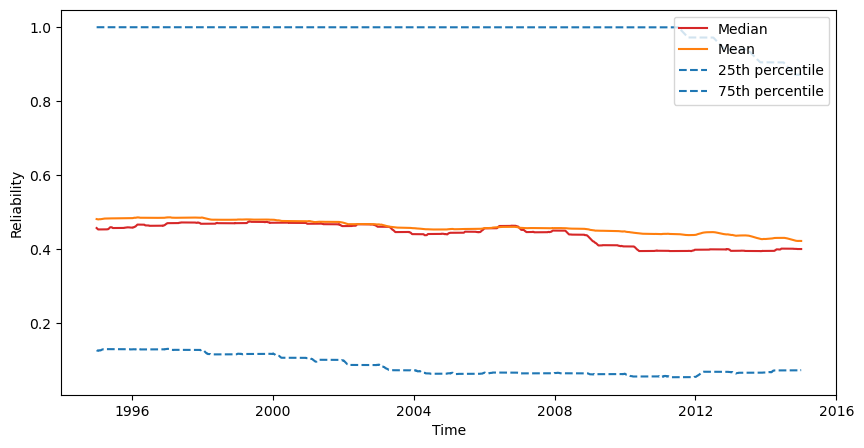

/var/folders/16/txrkznhx25n2cjbvr4p2vqgh0000gn/T/ipykernel_21440/3789403890.py:25: RuntimeWarning: Mean of empty slice
  ax.plot(date_range, np.nanmean(resilience_array, axis=0), label='Mean', color='tab:orange')


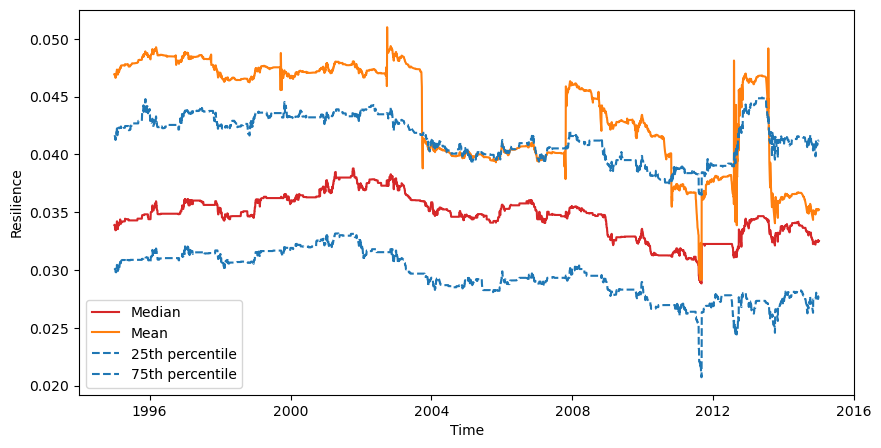

In [ ]:
# ---- Plot reliability, resilience, vulnerability time series ---- #

date_range = reliability_list[0].index    # date range of the moving-window sustainability metrics
reliability_array = np.array(reliability_list)    # (n_grid, n_window)
# plot reliability time series with confidence interval
fig, ax = plt.subplots(figsize=(10, 5))
# plot reliability time series of median and mean
ax.plot(date_range, np.nanmedian(reliability_array, axis=0), label='Median', color='tab:red')
ax.plot(date_range, np.nanmean(reliability_array, axis=0), label='Mean', color='tab:orange')
# plot reliability time series of 25th and 75th percentile
ax.plot(date_range, np.nanpercentile(reliability_array, 25, axis=0), linestyle='--', label='25th percentile', color='tab:blue')
ax.plot(date_range, np.nanpercentile(reliability_array, 75, axis=0), linestyle='--', label='75th percentile', color='tab:blue')

ax.set_xlabel('Time')
ax.set_ylabel('Reliability')

plt.legend()
plt.show()

resilience_array = np.array(resilience_list)    # (n_grid, n_window)
# plot resilience time series with confidence interval
fig, ax = plt.subplots(figsize=(10, 5))
# plot resilience time series of median and mean
ax.plot(date_range, np.nanmedian(resilience_array, axis=0), label='Median', color='tab:red')
ax.plot(date_range, np.nanmean(resilience_array, axis=0), label='Mean', color='tab:orange')
# plot resilience time series of 25th and 75th percentile
ax.plot(date_range, np.nanpercentile(resilience_array, 25, axis=0), linestyle='--', label='25th percentile', color='tab:blue')
ax.plot(date_range, np.nanpercentile(resilience_array, 75, axis=0), linestyle='--', label='75th percentile', color='tab:blue')

ax.set_xlabel('Time')
ax.set_ylabel('Resilience')

plt.legend()
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
flights = sns.load_dataset("flights")
flights

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


In [ ]:
flights.pivot

array('1990-01-01', dtype='datetime64[D]')

## Calculate sustainability index (entire period) & add to dataset

In [ ]:
# ---- Calculate sustainability index & add to dataset ---- #

# read simulation results
ds = xr.load_dataset(f'{output_dir}/{huc4}/model_states_{huc4}.nc')

# Omit the first 2 years of spinup
spinup_start = '1988-01-01'
spinup_end = '1990-01-01'
spinup_len = (pd.to_datetime(spinup_end) - pd.to_datetime(spinup_start)).days
# skip the first 2 years of spinup
ds = ds.isel(time=slice(spinup_len, None))

# get the grid indices that locate in the huc4: flow_direction != -1
huc4_lat_lon_tup = np.where(ds['flow_direction'] != -1)    # (lat_ind_array, lon_ind_array) pair

# loop through each grid cell & calculate sustainability index & add to the ds
reliability_array = np.ones_like(ds['water_deficit'].isel(time=0).values) * np.nan
resilience_array = np.ones_like(ds['water_deficit'].isel(time=0).values) * np.nan
vulnerability_array = np.ones_like(ds['water_deficit'].isel(time=0).values) * np.nan
for lat_ind, lon_ind in zip(huc4_lat_lon_tup[0], huc4_lat_lon_tup[1]):
    # get the water deficit time series
    deficit_array = ds['water_deficit'].isel(lat=lat_ind, lon=lon_ind).values
    
    # calculate sustainability index
    reliability = cal_reliability(deficit_array)
    resilience = cal_resilience(deficit_array)
    vulnerability = cal_vulnerability(deficit_array)

    # add to the array
    reliability_array[lat_ind, lon_ind] = reliability
    resilience_array[lat_ind, lon_ind] = resilience
    vulnerability_array[lat_ind, lon_ind] = vulnerability

# add to the ds
ds['reliability'] = (('lat', 'lon'), reliability_array)
ds['resilience'] = (('lat', 'lon'), resilience_array)
ds['vulnerability'] = (('lat', 'lon'), vulnerability_array)



## Visualize Sustainability Index

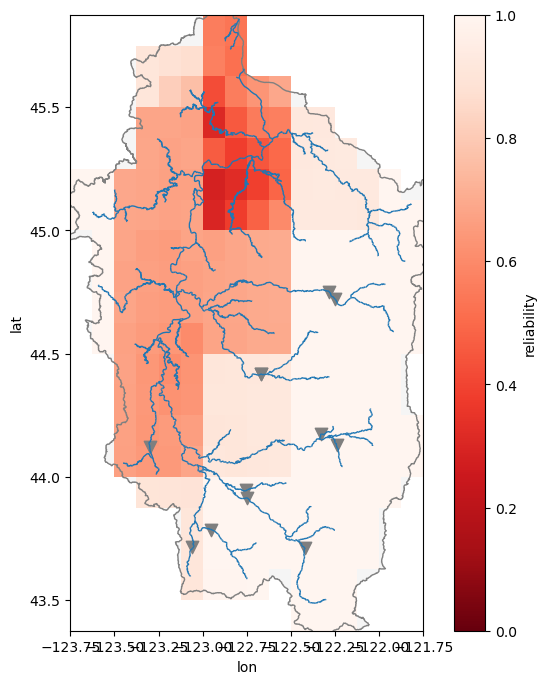

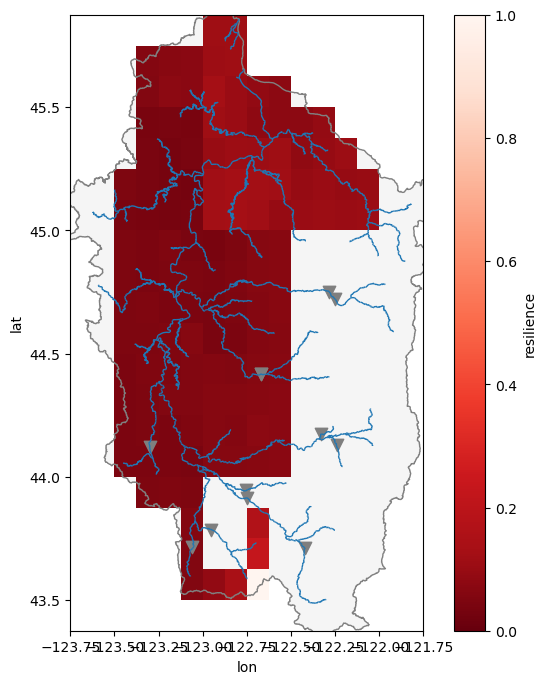

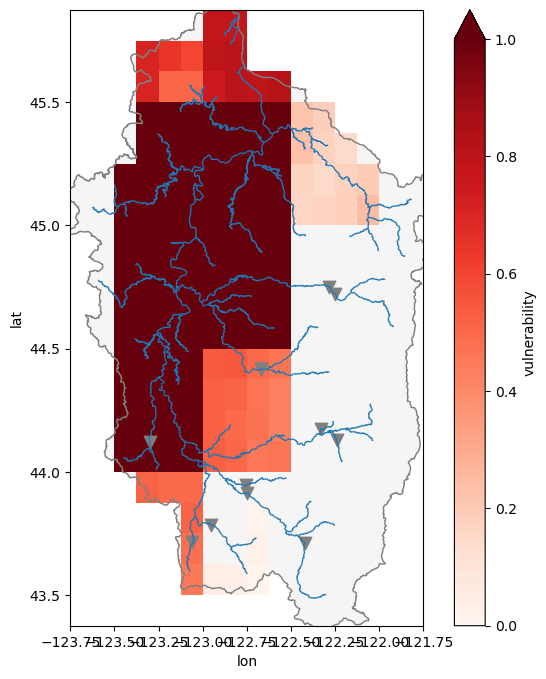

In [ ]:
# ---- Plot reliability, resilience, & vulnerability ---- #

plot_dict = {'reliability': 'Reds_r', 'resilience': 'Reds_r', 'vulnerability': 'Reds'}

for sus_ind, cmap in plot_dict.items():

    fig, ax = plt.subplots(figsize=(8, 8))

    # plot huc4 basin as background
    gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4].plot(ax=ax, facecolor='whitesmoke', edgecolor='none')

    # plot flow lines
    max_order = gdf_flow_huc4['StreamOrde'].max()
    min_order_to_keep = 4
    gdf_flow_huc4.loc[gdf_flow_huc4['StreamOrde']>=min_order_to_keep].plot(ax=ax, linewidth=1, color='tab:blue')

    # plot sustainability index
    ds[sus_ind].plot(ax=ax, cmap=cmap, vmin=0, vmax=1, alpha=1)

    # plot huc4 basin
    gdf_huc4_all.loc[gdf_huc4_all['huc4']==huc4].plot(ax=ax, facecolor='none', edgecolor='gray')

    # plot reservoirs
    gdf_reservoirs.loc[gdf_reservoirs['huc4']==huc4].plot(ax=ax, color='tab:gray', marker='v', markersize=80)

    plt.savefig(f'{output_dir}/{huc4}/sustainability_index_{sus_ind}.png', dpi=300, bbox_inches='tight')

    plt.show()

# Streamflow (Up vs. Downstream) Analysis

In [ ]:
# # read simulation results
# ds = xr.load_dataset(f'{output_dir}/{huc4}/model_states_{huc4}.nc')

# # Omit the first 2 years of spinup
# spinup_start = '1988-01-01'
# spinup_end = '1990-01-01'
# spinup_len = (pd.to_datetime(spinup_end) - pd.to_datetime(spinup_start)).days
# # skip the first 2 years of spinup
# ds = ds.isel(time=slice(spinup_len, None))

In [ ]:
# ---- Define functions for calculating drought index & drought characteristics ---- #

def cal_ssi_threshold(streamflow_series, quantile=0.25):
    """
    Calculate streamflow drought index based on the threshold method.

    streamflow_series: monthly streamflow Series, with datetime index
    """

    streamflow_monthly_mean = streamflow_series.groupby(streamflow_series.index.month).transform(lambda x: x.mean())
    streamflow_monthly_threshold = streamflow_series.groupby(streamflow_series.index.month).transform(lambda x: x.quantile(quantile))
    ssi = (streamflow_series - streamflow_monthly_threshold) / streamflow_monthly_mean

    return(ssi)

def cal_ssi_standardized(streamflow_series, mth_accum=3):
    """
    Calculate streamflow drought index based on the standardized method.
        Fit a Gamma distribution to the monthly streamflow data, and transform to z score.

    streamflow_series: monthly streamflow Series, with datetime index
    mon_acc: number of months to accumulate
    """

    # accumulate streamflow
    streamflow_series = streamflow_series.rolling(mth_accum).sum()

    # fit a Gamma distribution to the monthly streamflow data
    alpha, loc, beta = scipy.stats.gamma.fit(streamflow_series.dropna())

    # convert to SPI using normal distribution
    cdf_gamma = scipy.stats.gamma.cdf(streamflow_series, a=alpha, loc=loc, scale=beta)
    ssi = scipy.stats.norm.ppf(cdf_gamma)

    return(ssi)

def identify_drought_events(drought_index_series, threshold=0):
    """
    Identify all drought events based on the drought index time series.
        Drought event: consecutive months with drought index below the threshold

    drought_index_series: monthly drought index Series, with datetime index
    threshold: the threshold of drought index, below which to be considered as a drought

    Return:
        drought_event_list: list of drought events, each element is a tuple of (start_date, end_date)
    """

    drought_index_series = drought_index_series.dropna()    # drop NaN values coming from monthly accumulation

    # Identifying points where the index is below the threshold
    is_drought = drought_index_series < threshold

    # Identifying the start of drought events
    drought_start = is_drought & (~is_drought.shift(1, fill_value=False))

    # Identifying the end of drought events
    drought_end = is_drought & (~is_drought.shift(-1, fill_value=False))

    # Extracting start and end dates of droughts
    start_dates = drought_index_series.index[drought_start]
    end_dates = drought_index_series.index[drought_end]

    # Creating a list of tuples for each drought event
    drought_events = list(zip(start_dates, end_dates))

    # Check if it has been a drought at the begining, remove the first event if
    if is_drought[0] == True:
        drought_events.pop(0)
    
    # Check if the last drought event is still ongoing, remove the last event if
    if is_drought[-1] == True:
        drought_events.pop(-1)

    return drought_events

def cal_drought_duration(drought_event_list):
    """
    Return: list of drought duration for each drought event
    """
    
    drought_duration_list = [(end_date - start_date).days // 30 for start_date, end_date in drought_event_list]
    # it can come with 0, because I divide by 30, but Feb. has only 28 days
    # change 0 to 1
    drought_duration_list = [1 if i==0 else i for i in drought_duration_list]

    return(drought_duration_list)

def cal_drought_severity(drought_index_series, drought_event_list):
    """
    Return: list of drought severity for each drought event
    """

    drought_severity_list = []
    for start_date, end_date in drought_event_list:
        drought_severity = drought_index_series.loc[start_date:end_date].sum()
        drought_severity_list.append(-drought_severity)

    return(drought_severity_list)

def cal_drought_intensity(drought_index_series, drought_event_list):
    """
    Return: list of drought intensity for each drought event
    """

    drought_intensity_list = []
    for start_date, end_date in drought_event_list:
        drought_severity = drought_index_series.loc[start_date:end_date].sum()
        drought_duration = (end_date - start_date).days // 30
        drought_duration = drought_duration if drought_duration > 0 else 1
        drought_intensity = drought_severity / drought_duration
        drought_intensity_list.append(-drought_intensity)

    return(drought_intensity_list)

def cal_cdf(data_list):
    data_sorted = np.sort(data_list)
    cdf = np.arange(1, data_sorted.size + 1) / data_sorted.size
    return(data_sorted, cdf)

def cal_storage_drought_index(storage_series, quantile=0.25):
    """
    Calculate storage drought index based on the threshold method.

    storage_series: monthly storage Series, with datetime index
    """

    storage_monthly_mean = storage_series.groupby(storage_series.index.month).transform(lambda x: x.mean())
    storage_monthly_threshold = storage_series.groupby(storage_series.index.month).transform(lambda x: x.quantile(quantile))
    sdi = (storage_series - storage_monthly_threshold) / storage_monthly_mean

    return(sdi)



## Generate drought characteritics dataframe for each huc4 basin

In [ ]:
"""
Generate drought characteritics dataframe for each huc4 basin
    Saved as a single dataframe
"""

# read reservoir metadata for observed storage usage
df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx')

huc4_list = ['0108', '0110', '0301', '0305', '0306', '0313', '0315', '0505', '0507', '0509', '0511', '0512', '0513', '0601', '0602', '0603', '0701', '0702', '0708', '0710', '0714', '0902', '0804', '1003', '1008', '1012', '1018', '1025', '1026', '1027', '1028', '1029', '1101', '1102', '1107', '1111', '1114', '1201', '1202', '1203', '1210', '1302', '1307', '1401', '1402', '1404', '1506', '1602', '1703', '1704', '1705', '1709', '1711', '1802', '1803', '1804']

# initialize the dataframe with columns
df_ssi = pd.DataFrame()    # time series of standardized streamflow drought index, columns: {reservoir_id}_ssi_{mth_accum}
df_drought_char = pd.DataFrame(columns=['start_date', 'end_date', 'duration', 'intensity', 'severity', 'up_down', 'reservoir_id', 'huc4'])
for huc4 in huc4_list:
    # read simulation results for each huc4
    ds = xr.load_dataset(f'{output_dir}/{huc4}/model_states_{huc4}.nc')

    # Omit the first 2 years of spinup
    spinup_start = '1988-01-01'
    spinup_end = '1990-01-01'
    spinup_len = (pd.to_datetime(spinup_end) - pd.to_datetime(spinup_start)).days
    # skip the first 2 years of spinup
    ds = ds.isel(time=slice(spinup_len, None))

    # get the grid indices that locate in the huc4: flow_direction != -1
    # & the grid indices that have reservoirs: reservoir_id > 0
    res_grid_lat_lon_tup = np.where((ds['flow_direction'] != -1) & (ds['reservoir_id'] > 0))    # (lat_ind_array, lon_ind_array) pair

    # loop through each reservoir cell & calculate drought characteristics for each reservoir cell
    for lat_ind, lon_ind in zip(res_grid_lat_lon_tup[0], res_grid_lat_lon_tup[1]):
        res_gid = ds['reservoir_id'].isel(lat=lat_ind, lon=lon_ind).values

        # get the streamflow time series
        df_streamflow = ds[['outflow_before_operation', 'outflow_after_operation']].isel(lat=lat_ind, lon=lon_ind).drop_vars(['lat', 'lon']).to_dataframe()
        # convert object index to datetime index
        df_streamflow.index = pd.to_datetime(df_streamflow.index)

        # Calculate streamflow drought index for up- & downstream
        # 1. convert to monthly
        df_streamflow_monthly = df_streamflow.resample('MS').sum()

        # 2. calculate ssi
        # threshold-based method
        df_streamflow_monthly['outflow_before_operation_ssi_threshold'] = cal_ssi_threshold(df_streamflow_monthly['outflow_before_operation'])
        df_streamflow_monthly['outflow_after_operation_ssi_threshold'] = cal_ssi_threshold(df_streamflow_monthly['outflow_after_operation'])
        
        # standardized method
        mth_accum = 3
        # try-except to catch FitError: if the streamflow is too skewed to fit a gamma distribution, which probably comes from failed simulation
        try:
            df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'] = cal_ssi_standardized(df_streamflow_monthly['outflow_before_operation'], mth_accum)
            df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'] = cal_ssi_standardized(df_streamflow_monthly['outflow_after_operation'], mth_accum)
        except Exception as e:
            if type(e).__name__ == 'FitError':
                print(f'FitError: {res_gid} in {huc4}')
                continue
        # merge to df_ssi
        df_streamflow_monthly_to_merge = df_streamflow_monthly.rename(columns={f'outflow_before_operation_ssi_standardized_{mth_accum}': f'{res_gid}_upstream_ssi_{mth_accum}',
                                                                              f'outflow_after_operation_ssi_standardized_{mth_accum}': f'{res_gid}_downstream_ssi_{mth_accum}'}, inplace=False)
        df_ssi = pd.concat([df_ssi, df_streamflow_monthly_to_merge[[f'{res_gid}_upstream_ssi_{mth_accum}', f'{res_gid}_downstream_ssi_{mth_accum}']]], axis=1)

        # 3. identify drought events
        drought_list_upstream = identify_drought_events(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], threshold=0)
        drought_list_downstream = identify_drought_events(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], threshold=0)

        # drought numbers
        n_drought_upstream = len(drought_list_upstream)
        n_drought_downstream = len(drought_list_downstream)

        # drought duration
        drought_duration_upstream_list = cal_drought_duration(drought_list_upstream)
        drought_duration_downstream_list = cal_drought_duration(drought_list_downstream)

        # drought severity
        drought_severity_upstream_list = cal_drought_severity(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], drought_list_upstream)
        drought_severity_downstream_list = cal_drought_severity(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], drought_list_downstream)

        # drought intensity
        drought_intensity_upstream_list = cal_drought_intensity(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], drought_list_upstream)
        drought_intensity_downstream_list = cal_drought_intensity(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], drought_list_downstream)

        # add to the dataframe, use pd.concat
        # add upstream drought 
        df_drought_char = pd.concat([df_drought_char, pd.DataFrame({'start_date': [start_date for start_date, end_date in drought_list_upstream],
                                                                    'end_date': [end_date for start_date, end_date in drought_list_upstream],
                                                                    'duration': drought_duration_upstream_list,
                                                                    'intensity': drought_intensity_upstream_list,
                                                                    'severity': drought_severity_upstream_list,
                                                                    'up_down': 'upstream',
                                                                    'reservoir_id': res_gid,
                                                                    'huc4': huc4})])

        # add downstream drought
        df_drought_char = pd.concat([df_drought_char, pd.DataFrame({'start_date': [start_date for start_date, end_date in drought_list_downstream],
                                                                    'end_date': [end_date for start_date, end_date in drought_list_downstream],
                                                                    'duration': drought_duration_downstream_list,
                                                                    'intensity': drought_intensity_downstream_list,
                                                                    'severity': drought_severity_downstream_list,
                                                                    'up_down': 'downstream',
                                                                    'reservoir_id': res_gid,
                                                                    'huc4': huc4})])        
        
    # delete the ds to save memory
    del ds
    gc.collect()
        

In [ ]:
# # ---- Save to excel ---- #

# df_drought_char.to_excel(f'{output_dir}/drought_characteristics_ssi{mth_accum}.xlsx', index=False)

In [ ]:
# ---- Generate basin-lumped storage drought index & drought characteristics dataframe for each huc4 basin ---- #
# ---- # currently use observed storage, and varied threshold to define storage drought ---- #

# read reservoir metadata for observed storage usage
df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx', dtype={'huc4':str})

huc4_list = ['1709', '1705', '1804', '1203']

# initialize a dataframe to store basin-level storage time series for all basins, column names are basin huc4
df_storage_all_huc4 = pd.DataFrame()

# Loop each huc4 basin
for huc4 in huc4_list:
    # get list of reservoirs in this huc4
    res_gid_list = df_res_meta.loc[df_res_meta['huc4']==huc4, 'ID'].tolist()

    # Create a dataframe to store storage of each reservoir
    df_storage_huc4 = pd.DataFrame()

    # Loop through each reservoir, and add all storage together
    for res_gid in res_gid_list:
        # read storage data and add to basin-level df
        reservoir_smax = df_res_meta.loc[df_res_meta['ID']==res_gid, 'Maximum Storage'].values[0]
        df_res = pd.read_csv(f'{reservoir_data_dir}/data_training/{res_gid}.csv')
        df_res[['Storage', 'NetInflow', 'Release']] = df_res[['Storage', 'NetInflow', 'Release']] * reservoir_smax
        df_res['Time'] = pd.to_datetime(df_res['Time'])
        df_res.set_index('Time', inplace=True)
        # if df_res has duplicate index, drop the duplicate. This can happen when observations have the same date mistakenly.
        if df_res.index.duplicated().any():
            df_res = df_res[~df_res.index.duplicated(keep='first')]
        # drop the first 2 years of spinup if exists
        df_res = df_res.loc[df_res.index >= spinup_end]

        # add to basin-level df
        df_storage_huc4 = pd.concat([df_storage_huc4, df_res['Storage'].rename(f'{res_gid}_storage')], axis=1)

    # Post-process the basin-level storage dataframe before adding to all-basin dataframe
    # drop NaNs which are at the begining and end
    df_storage_huc4['total_storage_temp'] = df_storage_huc4.sum(axis=1, skipna=False)    # this temp sum is created to get the first and last valid index
    first_idx = df_storage_huc4['total_storage_temp'].first_valid_index()
    last_idx = df_storage_huc4['total_storage_temp'].last_valid_index()
    df_storage_huc4 = df_storage_huc4.loc[first_idx:last_idx]
    # drop the temp column
    df_storage_huc4.drop(columns=['total_storage_temp'], inplace=True)

    # change to monthly
    df_storage_huc4.index = pd.to_datetime(df_storage_huc4.index)
    df_storage_huc4 = df_storage_huc4.resample('MS').mean()

    # fill NaN with time period
    df_storage_huc4 = df_storage_huc4.interpolate(method='time')

    # sum all storage
    df_storage_huc4[f'total_storage_{huc4}'] = df_storage_huc4.sum(axis=1, skipna=False)

    # Add to all-basin dataframe, using outer join
    df_storage_all_huc4 = df_storage_all_huc4.join(df_storage_huc4[f'total_storage_{huc4}'], how='outer')

# Calculate storage drought index for each huc4 basin, from df_storage_all_huc4, already monthly
for huc4 in huc4_list:
    df_storage_all_huc4[f'storage_drought_index_{huc4}'] = cal_storage_drought_index(df_storage_all_huc4[f'total_storage_{huc4}'])


In [ ]:
# Plot reservoir storage distributions

# # Plot storage distributions for each huc4 basin
# for i, huc4 in enumerate(huc4_list):
#     fig, ax = plt.subplots()
#     df_res_meta.loc[df_res_meta['huc4']==huc4, 'Maximum Storage'].sort_values(ascending=False).plot(kind='bar', ax=ax)
#     ax.set_xlabel('Reservoirs')
#     ax.set_ylabel('Maximum Storage (acre-feet)')
#     ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     ax.set_xticks([])
#     plt.show()

# pie plot of reservoir operation type within each huc4 basin
color_map = {
        'Hydroelectricity': 'tab:blue',
        'Irrigation': 'tab:orange',
        'Flood control': 'tab:green',
        'Water supply': 'tab:red',
        'Recreation': 'tab:purple'
    }
for huc4 in huc4_list:
    print(huc4)
    pie_counts = df_res_meta.loc[df_res_meta['huc4']==huc4, 'MAIN_USE'].value_counts()
    color_list = [color_map[use] for use in pie_counts.index]

    fig, ax = plt.subplots()
    pie_counts.plot(kind='pie', ax=ax, colors=color_list)
    ax.set_ylabel('')
    ax.legend(loc='upper left', facecolor='white', bbox_to_anchor=(1, 1))

    # make background transparent
    fig.patch.set_alpha(1)

    plt.show()

# Plot total storage distribution of all basins
df_plot = pd.DataFrame(columns=['total_max_storage'], index=huc4_list)
for huc4 in huc4_list:
    max_storage_huc4 = df_res_meta.loc[df_res_meta['huc4']==huc4, 'Maximum Storage'].sum()
    df_plot.loc[huc4, 'total_max_storage'] = max_storage_huc4

fig, ax = plt.subplots()
df_plot.plot(kind='bar', ax=ax, legend=False, color='tab:orange')
ax.set_xlabel('HUC4 Basins')
ax.set_ylabel('Total Storage Capacity (acre-feet)')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xticks(rotation=0)
plt.show()



In [ ]:
# ---- Generate storage drought index for each single reservoir ---- #
# ---- # currently use observed storage, and varied threshold to define storage drought ---- #

# read reservoir metadata for observed storage usage
df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx', dtype={'huc4':str})

huc4_list = ['1709', '1705', '1804', '1203']

df_storage_res = pd.DataFrame()    # columns: {reservoir_id}_storage, {reservoir_id}_storage_drought_index
# Loop each huc4 basin
for huc4 in huc4_list:
    # get list of reservoirs in this huc4
    res_gid_list = df_res_meta.loc[df_res_meta['huc4']==huc4, 'ID'].tolist()

    # Loop through each reservoir, and add all storage together
    for res_gid in res_gid_list:
        # read storage data and add to basin-level df
        reservoir_smax = df_res_meta.loc[df_res_meta['ID']==res_gid, 'Maximum Storage'].values[0]
        df_res = pd.read_csv(f'{reservoir_data_dir}/data_training/{res_gid}.csv')
        df_res[['Storage', 'NetInflow', 'Release']] = df_res[['Storage', 'NetInflow', 'Release']] * reservoir_smax
        df_res['Time'] = pd.to_datetime(df_res['Time'])
        df_res.set_index('Time', inplace=True)
        # if df_res has duplicate index, drop the duplicate. This can happen when observations have the same date mistakenly.
        if df_res.index.duplicated().any():
            df_res = df_res[~df_res.index.duplicated(keep='first')]
        # drop the first 2 years of spinup if exists
        df_res = df_res.loc[df_res.index >= spinup_end]

        # add to df_storage_res
        df_res.rename(columns={'Storage': f'{res_gid}_storage'}, inplace=True)
        df_storage_res = df_storage_res.join(df_res[f'{res_gid}_storage'], how='outer')

# reshape to monthly
df_storage_res = df_storage_res.resample('MS').mean()
# calculate storage drought index
for res_gid in df_storage_res.columns.str.split('_').str[0]:
    # Remove the first and last NaNs for each reservoir
    storage_series = df_storage_res[f'{res_gid}_storage']
    first_idx = storage_series.first_valid_index()
    last_idx = storage_series.last_valid_index()
    storage_series = storage_series.loc[first_idx:last_idx]
    
    # fill NaN with time period
    storage_series = storage_series.interpolate(method='time')

    # calculate storage drought index
    df_storage_res[f'{res_gid}_storage_drought_index'] = cal_storage_drought_index(storage_series)


## Plot Event-scale Storage Index & Streamflow Drought Index

In [ ]:
# use df_storage_res from above 

df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx', dtype={'huc4':str})

for res_gid in df_res_meta.loc[df_res_meta['huc4'].isin(huc4_list), 'ID']:

    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot streamflow drought time series
    try:
        df_ssi[f'{res_gid}_upstream_ssi_{mth_accum}'].plot(ax=ax, color='tab:blue', label='Upstream', linewidth=1)
        df_ssi[f'{res_gid}_downstream_ssi_{mth_accum}'].plot(ax=ax, color='tab:orange', label='Downstream', linewidth=1)
        ax.legend()

        # plot storage drought index time series on twin axis
        ax2 = ax.twinx()
        df_storage_res[f'{res_gid}_storage_drought_index'].dropna().plot(ax=ax2, color='tab:red', label='Storage', linewidth=1.5)
        ax2.legend()

    except KeyError:
        print(f'{res_gid} not found in df_ssi or df_storage_res')
        continue

    # make ax and ax2 aligned by setting the same ylim
    ax.set_ylim([-3, 3])
    ax2.set_ylim([-2, 2])

    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

    plt.savefig(f'{output_dir}/{res_gid}_drought_index.jpg', dpi=300)
    plt.close()

## Analysis of Streamflow Drought Characteristics

In [ ]:
# ---- Read the results for all huc4 basins ---- #

mth_accum = 3
df_drought_char = pd.read_excel(f'{output_dir}/drought_characteristics_ssi{mth_accum}.xlsx', dtype={'huc4':str})


# read reservoirs to drop from the analysis
with open('code/reservoirs_to_drop.txt', 'r') as f:
    reservoirs_to_drop = f.read().splitlines()[0]    # only one line
reservoirs_to_drop = [int(i) for i in reservoirs_to_drop.split(',')]   

In [ ]:
"""
Plot upstream & downstream drought characteristics, by huc4
"""
# plot drought duration
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df_drought_char, x='huc4', y='duration', hue='up_down', ax=ax, showfliers=False)
ax.set_title(f'Drought Duration')
ax.set_ylabel('Drought Duration (months)')
ax.legend(title='')
plt.savefig(f'figures/upstream_downstream_ssi_distribution/drought_duration_ssi{mth_accum}.jpg', dpi=100, bbox_inches='tight')
plt.show()

# plot drought intensity
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df_drought_char, x='huc4', y='intensity', hue='up_down', ax=ax, showfliers=False)
ax.set_title(f'Drought Intensity')
ax.set_ylabel('Drought Intensity')
ax.legend(title='')
plt.savefig(f'figures/upstream_downstream_ssi_distribution/drought_intensity_ssi{mth_accum}.jpg', dpi=100, bbox_inches='tight')
plt.show()

# plot drought severity
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df_drought_char, x='huc4', y='severity', hue='up_down', ax=ax, showfliers=False)
ax.set_title(f'Drought Severity')
ax.set_ylabel('Drought Severity')
ax.legend(title='')
plt.savefig(f'figures/upstream_downstream_ssi_distribution/drought_severity_ssi{mth_accum}.jpg', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
"""
Plot average change of drought characteristics between upstream and downstream, by each reservoir
"""

# read the results for all huc4 basins
mth_accum = 3
df_drought_char = pd.read_excel(f'{output_dir}/drought_characteristics_ssi{mth_accum}.xlsx', dtype={'huc4':str})

# drop reservoirs to drop
df_drought_char = df_drought_char[~df_drought_char['reservoir_id'].isin(reservoirs_to_drop)]

# Calculate average change of drought characteristics
# 1. group by reservoir & upstream/downstream
df_drought_char_reservoir_mean = df_drought_char.groupby(['reservoir_id', 'up_down']).mean(numeric_only=True).reset_index()
df_drought_char_reservoir_75 = df_drought_char.groupby(['reservoir_id', 'up_down']).quantile(0.75, numeric_only=True).reset_index()
df_drought_char_reservoir_25 = df_drought_char.groupby(['reservoir_id', 'up_down']).quantile(0.25, numeric_only=True).reset_index()
# add # of drought events for each reservoir
df_drought_char_reservoir_mean['n_drought'] = df_drought_char.groupby(['reservoir_id', 'up_down']).size().reset_index(name='n_drought')['n_drought']
df_drought_char_reservoir_75['n_drought'] = df_drought_char.groupby(['reservoir_id', 'up_down']).size().reset_index(name='n_drought')['n_drought']
df_drought_char_reservoir_25['n_drought'] = df_drought_char.groupby(['reservoir_id', 'up_down']).size().reset_index(name='n_drought')['n_drought']
# 2. calculate the change: (downstream - upstream) / upstream, pivot to wide format
df_drought_char_reservoir_mean_pivoted = df_drought_char_reservoir_mean.pivot(index='reservoir_id', columns='up_down', values=['n_drought', 'duration', 'intensity', 'severity'])
df_drought_char_reservoir_mean_pivoted.columns = [f'{col}_{up_down}' for col, up_down in df_drought_char_reservoir_mean_pivoted.columns]
df_drought_char_reservoir_75_pivoted = df_drought_char_reservoir_75.pivot(index='reservoir_id', columns='up_down', values=['n_drought', 'duration', 'intensity', 'severity'])
df_drought_char_reservoir_75_pivoted.columns = [f'{col}_{up_down}' for col, up_down in df_drought_char_reservoir_75_pivoted.columns]
df_drought_char_reservoir_25_pivoted = df_drought_char_reservoir_25.pivot(index='reservoir_id', columns='up_down', values=['n_drought', 'duration', 'intensity', 'severity'])
df_drought_char_reservoir_25_pivoted.columns = [f'{col}_{up_down}' for col, up_down in df_drought_char_reservoir_25_pivoted.columns]

for col in ['n_drought', 'duration', 'intensity', 'severity']:
    df_drought_char_reservoir_mean_pivoted[f'{col}_change'] = (df_drought_char_reservoir_mean_pivoted[f'{col}_downstream'] - df_drought_char_reservoir_mean_pivoted[f'{col}_upstream']) / df_drought_char_reservoir_mean_pivoted[f'{col}_upstream']
    df_drought_char_reservoir_75_pivoted[f'{col}_change'] = (df_drought_char_reservoir_75_pivoted[f'{col}_downstream'] - df_drought_char_reservoir_75_pivoted[f'{col}_upstream']) / df_drought_char_reservoir_75_pivoted[f'{col}_upstream']
    df_drought_char_reservoir_25_pivoted[f'{col}_change'] = (df_drought_char_reservoir_25_pivoted[f'{col}_downstream'] - df_drought_char_reservoir_25_pivoted[f'{col}_upstream']) / df_drought_char_reservoir_25_pivoted[f'{col}_upstream']

# Drop reservoirs with NaNs
df_drought_char_reservoir_mean_pivoted = df_drought_char_reservoir_mean_pivoted.dropna()
df_drought_char_reservoir_75_pivoted = df_drought_char_reservoir_75_pivoted.dropna()
df_drought_char_reservoir_25_pivoted = df_drought_char_reservoir_25_pivoted.dropna()

# Merge with reservoir metadata, for analysis by some attributes
df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx', dtype={'huc4':str})
df_drought_char_reservoir_mean_pivoted = df_drought_char_reservoir_mean_pivoted.reset_index().merge(df_res_meta[['ID', 'MAIN_USE', 'Maximum Storage', 'huc4']], left_on='reservoir_id', right_on='ID').drop(columns='ID')

# ---- Plot ---- #
plt.style.use('ggplot')
# plot mean change
fig, ax = plt.subplots()
df_drop_outliers = df_drought_char_reservoir_mean_pivoted.loc[df_drought_char_reservoir_mean_pivoted['n_drought_change'] < 10]
sns.boxplot(data=df_drop_outliers[['n_drought_change', 'duration_change', 'intensity_change', 'severity_change']], 
            ax=ax, showfliers=False)

ax.set_ylim([-1, 1])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylabel('Reservoir Influence')


ax.set_xticklabels(['# events', 'Duration', 'Intensity', 'Severity'])
plt.savefig(f'/Users/donghui/Box Sync/UIUC/Group Meeting/2024-SPRING/my_presentation/figures/drought_characteristics_change_ssi{mth_accum}.jpg', dpi=300, bbox_inches='tight')
plt.show()

# # plot mean change by reservoir use
# for res_use in df_drought_char_reservoir_mean_pivoted['MAIN_USE'].unique():
#     fig, ax = plt.subplots()
#     sns.boxplot(data=df_drought_char_reservoir_mean_pivoted.loc[df_drought_char_reservoir_mean_pivoted['MAIN_USE']==res_use, ['n_drought_change', 'duration_change', 'intensity_change', 'severity_change']], 
#                 ax=ax, showfliers=False)

#     ax.set_ylim([-1, 1])
#     ax.set_xticklabels(['# events', 'Duration', 'Intensity', 'Severity'])
#     ax.axhline(y=0, color='tab:gray', linestyle='-', linewidth=1)
#     ax.set_title(res_use)
#     plt.show()

# plot mean change by huc2 region
df_drought_char_reservoir_mean_pivoted['huc2'] = df_drought_char_reservoir_mean_pivoted['huc4'].str[0:2]
df_drought_char_reservoir_mean_pivoted.sort_values('huc2', inplace=True)
for huc2 in df_drought_char_reservoir_mean_pivoted['huc2'].unique():
    fig, ax = plt.subplots()
    sns.boxplot(data=df_drought_char_reservoir_mean_pivoted.loc[df_drought_char_reservoir_mean_pivoted['huc2']==huc2, ['n_drought_change', 'duration_change', 'intensity_change', 'severity_change']], 
                ax=ax, showfliers=False)

    ax.set_ylim([-1, 1])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylabel('Reservoir Influence')

    ax.set_xticklabels(['# events', 'Duration', 'Intensity', 'Severity'])
    
    plt.savefig(f'/Users/donghui/Box Sync/UIUC/Group Meeting/2024-SPRING/my_presentation/figures/drought_characteristics_change_ssi{mth_accum}_{huc2}.jpg', dpi=300, bbox_inches='tight')
    plt.show()

# # plot 75th percentile change
# fig, ax = plt.subplots()
# sns.boxplot(data=df_drought_char_reservoir_75_pivoted[['n_drought_change', 'duration_change', 'intensity_change', 'severity_change']], 
#             ax=ax, showfliers=False,
#             medianprops=dict(color='black', linewidth=2))

# ax.set_xticklabels(['# events', 'Duration', 'Intensity', 'Severity'])
# ax.axhline(y=0, color='tab:gray', linestyle='-', linewidth=1)
# plt.show()

# # plot 25th percentile change
# fig, ax = plt.subplots()
# sns.boxplot(data=df_drought_char_reservoir_25_pivoted[['n_drought_change', 'duration_change', 'intensity_change', 'severity_change']], 
#             ax=ax, showfliers=False,
#             medianprops=dict(color='black', linewidth=2))

# ax.set_xticklabels(['# events', 'Duration', 'Intensity', 'Severity'])
# ax.axhline(y=0, color='tab:gray', linestyle='-', linewidth=1)
# plt.show()







### Up-Downstream Change Clustering - 2
- Use `df_drought_char_reservoir_mean_pivoted`
- Seems **NO** meaningful clusters after investigation

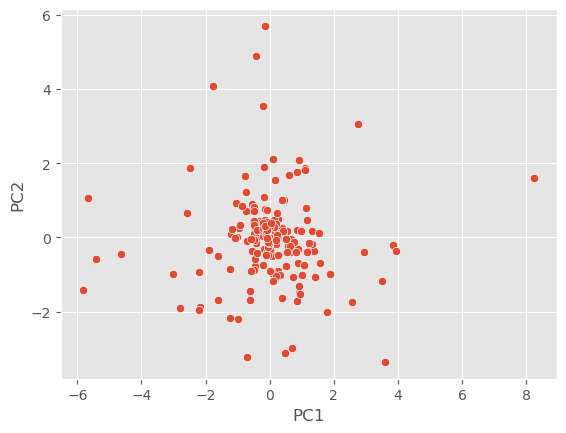

In [ ]:
"""
PCA analysis
"""

# remove outliers
threshold = 2
df_drought_char_reservoir_mean_pivoted_wt_outliers = df_drought_char_reservoir_mean_pivoted.loc[
    (df_drought_char_reservoir_mean_pivoted['n_drought_change'] < threshold) &
    (df_drought_char_reservoir_mean_pivoted['duration_change'] < threshold) &
    (df_drought_char_reservoir_mean_pivoted['intensity_change'] < threshold) &
    (df_drought_char_reservoir_mean_pivoted['severity_change'] < threshold)].copy(deep=True)

xcols = ['n_drought_change', 'duration_change', 'intensity_change', 'severity_change', 'Maximum Storage']

# standardize the data
scaler = StandardScaler()
df_drought_char_reservoir_mean_pivoted_wt_outliers[xcols] = scaler.fit_transform(df_drought_char_reservoir_mean_pivoted_wt_outliers[xcols])

# PCA
n = 4
pca = PCA(n_components=n)
pca.fit(df_drought_char_reservoir_mean_pivoted_wt_outliers[xcols])

# scatter plot of the first 2 PCs
X_transform = pca.transform(df_drought_char_reservoir_mean_pivoted_wt_outliers[xcols])
df_pca = pd.DataFrame(X_transform, columns=[f'PC{i+1}' for i in range(n)], index=df_drought_char_reservoir_mean_pivoted_wt_outliers['reservoir_id'])

fig, ax = plt.subplots()
sns.scatterplot(data=df_pca, x='PC1', y='PC2', ax=ax)
plt.show()


In [ ]:
"""
Agglomerative Clustering
    Cluster the reservoirs
"""

# remove outliers
threshold = 2
df_drought_char_reservoir_mean_pivoted_wt_outliers = df_drought_char_reservoir_mean_pivoted.loc[
    (df_drought_char_reservoir_mean_pivoted['n_drought_change'] < threshold) &
    (df_drought_char_reservoir_mean_pivoted['duration_change'] < threshold) &
    (df_drought_char_reservoir_mean_pivoted['intensity_change'] < threshold) &
    (df_drought_char_reservoir_mean_pivoted['severity_change'] < threshold)].copy(deep=True)

model = AgglomerativeClustering(n_clusters=5)
# clustering = model.fit(df_drought_char_reservoir_mean_pivoted_wt_outliers[['n_drought_change', 'duration_change', 'intensity_change', 'severity_change']])


In [ ]:
"""
KMeans Clustering
"""

# remove outliers
threshold = 2
df_drought_char_reservoir_mean_pivoted_wt_outliers = df_drought_char_reservoir_mean_pivoted.loc[
    (df_drought_char_reservoir_mean_pivoted['n_drought_change'] < threshold) &
    (df_drought_char_reservoir_mean_pivoted['duration_change'] < threshold) &
    (df_drought_char_reservoir_mean_pivoted['intensity_change'] < threshold) &
    (df_drought_char_reservoir_mean_pivoted['severity_change'] < threshold)].copy(deep=True)

model = KMeans(n_clusters=5)
# clustering = model.fit(df_drought_char_reservoir_mean_pivoted_wt_outliers[['n_drought_change', 'duration_change', 'intensity_change', 'severity_change']])
clustering = model.fit(df_drought_char_reservoir_mean_pivoted_wt_outliers[['duration_change', 'intensity_change', 'severity_change']])


In [ ]:
"""
Plot clusters on two dimensions
"""

# add cluster labels to df_drought_char_reservoir_mean_pivoted
df_drought_char_reservoir_mean_pivoted_wt_outliers['cluster'] = clustering.labels_

# plot clusters on 2D
for x in ['n_drought_change', 'duration_change', 'intensity_change', 'severity_change']:
    for y in ['n_drought_change', 'duration_change', 'intensity_change', 'severity_change']:
        if x != y:
            fig, ax = plt.subplots()
            sns.scatterplot(data=df_drought_char_reservoir_mean_pivoted_wt_outliers,
                            x=x, y=y, hue=clustering.labels_, ax=ax, palette='tab10', alpha=0.7)
            plt.show()


plt.show()

In [ ]:
"""
Plot the clusters on map
"""

df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx', dtype={'huc4':str})

# add cluster labels to df_drought_char_reservoir_mean_pivoted
df_drought_char_reservoir_mean_pivoted_wt_outliers['cluster'] = clustering.labels_

# merge with reservoir metadata
df_drought_char_clustered = df_drought_char_reservoir_mean_pivoted_wt_outliers.merge(df_res_meta[['ID', 'lattitude', 'longtitude']], left_on='reservoir_id', right_on='ID').drop(columns='ID')

# convert to geodataframe
gdf_drought_char_clustered = gpd.GeoDataFrame(df_drought_char_clustered, geometry=gpd.points_from_xy(df_drought_char_clustered['longtitude'], df_drought_char_clustered['lattitude']))
gdf_drought_char_clustered.set_crs(crs, inplace=True)

# Concat huc4 gdf of each huc2
gdf_huc4_conus = gpd.GeoDataFrame()
gdf_huc2_conus = gpd.GeoDataFrame()
for huc2 in huc2_conus:
    # read HUC2s
    gdb_file = f'{nhd_data_dir}/Raw/WBD/WBD_{huc2}_HU2_GDB.gdb'
    gdf_huc4_in_huc2 = gpd.read_file(gdb_file, layer='WBDHU4')
    gdf_huc2 = gpd.read_file(gdb_file, layer='WBDHU2')

    # add to the conus gdf
    gdf_huc4_conus = pd.concat([gdf_huc4_conus, gdf_huc4_in_huc2], ignore_index=True)
    gdf_huc2_conus = pd.concat([gdf_huc2_conus, gdf_huc2], ignore_index=True)

# ---- Plot ---- #
fig, ax = plt.subplots(figsize=(15, 12))

# plot huc2
gdf_huc2_conus.plot(ax=ax, facecolor='whitesmoke', edgecolor='tab:gray', linewidth=1)

gdf_drought_char_clustered.plot(ax=ax, column='cluster', cmap='Dark2', legend=False, markersize=50, alpha=0.7)

plt.show()


In [ ]:
df_res_meta

,ID,Dam name,state,longtitude,lattitude,MAIN_USE,USE_IRRI,USE_ELEC,USE_SUPP,USE_FCON,USE_RECR,USE_NAVI,Maximum Storage,GRAND_ID,huc4
0,2149,Franklin Falls Dam,New Hampshire,-71.656250,43.453750,Hydroelectricity,NaN,Main,NaN,NaN,NaN,NaN,43850.0,2149,0107
1,2158,Hopkinton Flood Control Dam,New Hampshire,-71.747083,43.188750,Flood control,NaN,NaN,NaN,Main,NaN,NaN,76760.0,2158,0107
2,2188,Littleville Dam,Massachusetts,-72.882350,42.266120,Flood control,NaN,NaN,Sec,Main,NaN,NaN,25598.0,2188,0108
3,2193,Colebrook River Dam,Connecticut,-73.020417,41.991250,Flood control,NaN,NaN,Sec,Main,Sec,NaN,74908.0,2193,0108
4,10007,North Hartland,Vermont,-72.360561,43.604939,Flood control,NaN,Sec,NaN,Main,Sec,NaN,43260.0,10007,0108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,585,Buchanan Dam,California,-119.985417,37.220417,Flood control,Sec,NaN,NaN,Main,Sec,NaN,145460.0,585,1804
448,592,Hidden Dam,California,-119.882917,37.112083,Flood control,Sec,NaN,NaN,Main,Sec,NaN,88560.0,592,1804
449,595,Friant,California,-119.703750,37.003750,Irrigation,Main,NaN,NaN,Sec,NaN,NaN,529758.0,595,1804
450,10004,Mariposa Reservoir,California,-120.147000,37.292000,Flood control,NaN,NaN,NaN,Main,NaN,NaN,15873.0,10004,1804


In [ ]:
# ---- Plot streamflow drought characteristics (cumulative density) ---- #

# get the grid indices that locate in the huc4: flow_direction != -1
# & the grid indices that have reservoirs: reservoir_id > 0
res_grid_lat_lon_tup = np.where((ds['flow_direction'] != -1) & (ds['reservoir_id'] > 0))    # (lat_ind_array, lon_ind_array) pair

# loop through each reservoir cell & do the analysis
for lat_ind, lon_ind in zip(res_grid_lat_lon_tup[0], res_grid_lat_lon_tup[1]):
    res_gid = ds['reservoir_id'].isel(lat=lat_ind, lon=lon_ind).values
    print(res_gid)

    # get streamflow time series
    df_streamflow = ds[['outflow_before_operation', 'outflow_after_operation']].isel(lat=lat_ind, lon=lon_ind).drop_vars(['lat', 'lon']).to_dataframe()
    # convert object index to datetime index
    df_streamflow.index = pd.to_datetime(df_streamflow.index)

    # Calculate streamflow drought index for up- & downstream
    # 1. convert to monthly
    df_streamflow_monthly = df_streamflow.resample('MS').sum()

    # 2. calculate ssi
    df_streamflow_monthly['outflow_before_operation_ssi_threshold'] = cal_ssi_threshold(df_streamflow_monthly['outflow_before_operation'])
    df_streamflow_monthly['outflow_after_operation_ssi_threshold'] = cal_ssi_threshold(df_streamflow_monthly['outflow_after_operation'])
    
    mth_accum = 3
    df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'] = cal_ssi_standardized(df_streamflow_monthly['outflow_before_operation'], mth_accum)
    df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'] = cal_ssi_standardized(df_streamflow_monthly['outflow_after_operation'], mth_accum)

    # Analyze drought events
    drought_list_upstream = identify_drought_events(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], threshold=0)
    drought_list_downstream = identify_drought_events(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], threshold=0)

    # drought numbers
    n_drought_upstream = len(drought_list_upstream)
    n_drought_downstream = len(drought_list_downstream)

    # drought duration
    drought_duration_upstream_list = cal_drought_duration(drought_list_upstream)
    drought_duration_downstream_list = cal_drought_duration(drought_list_downstream)

    # drought severity
    drought_severity_upstream_list = cal_drought_severity(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], drought_list_upstream)
    drought_severity_downstream_list = cal_drought_severity(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], drought_list_downstream)

    # drought intensity
    drought_intensity_upstream_list = cal_drought_intensity(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], drought_list_upstream)
    drought_intensity_downstream_list = cal_drought_intensity(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], drought_list_downstream)

    # Plot cdf
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    # duration
    data_sorted, cdf = cal_cdf(drought_duration_upstream_list)
    ax[0].plot(data_sorted, cdf, label='upstream')
    data_sorted, cdf = cal_cdf(drought_duration_downstream_list)
    ax[0].plot(data_sorted, cdf, label='downstream')
    ax[0].set_xlabel('Drought duration (months)')
    ax[0].set_ylabel('Cumulative probability')

    # severity
    data_sorted, cdf = cal_cdf(drought_severity_upstream_list)
    ax[1].plot(data_sorted, cdf, label='upstream')
    data_sorted, cdf = cal_cdf(drought_severity_downstream_list)
    ax[1].plot(data_sorted, cdf, label='downstream')
    ax[1].set_xlabel('Drought severity (unitless)')
    ax[1].set_ylabel('Cumulative probability')

    # intensity
    data_sorted, cdf = cal_cdf(drought_intensity_upstream_list)
    ax[2].plot(data_sorted, cdf, label='upstream')
    data_sorted, cdf = cal_cdf(drought_intensity_downstream_list)
    ax[2].plot(data_sorted, cdf, label='downstream')
    ax[2].set_xlabel('Drought intensity (unitless)')
    ax[2].set_ylabel('Cumulative probability')

    ax[0].legend()

    # plt.savefig(f'{output_dir}/{huc4}/drought_cdf_{res_gid}.png', dpi=300, bbox_inches='tight')
    plt.show()
    

In [ ]:
# ---- Plot streamflow drought characteristics ---- #

# get the grid indices that locate in the huc4: flow_direction != -1
# & the grid indices that have reservoirs: reservoir_id > 0
res_grid_lat_lon_tup = np.where((ds['flow_direction'] != -1) & (ds['reservoir_id'] > 0))    # (lat_ind_array, lon_ind_array) pair

# read reservoir storage observation
df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx')

# loop through each reservoir cell & do the analysis
for lat_ind, lon_ind in zip(res_grid_lat_lon_tup[0], res_grid_lat_lon_tup[1]):
    res_gid = ds['reservoir_id'].isel(lat=lat_ind, lon=lon_ind).values
    print(res_gid)

    # get streamflow time series
    df_streamflow = ds[['outflow_before_operation', 'outflow_after_operation']].isel(lat=lat_ind, lon=lon_ind).drop_vars(['lat', 'lon']).to_dataframe()
    # convert object index to datetime index
    df_streamflow.index = pd.to_datetime(df_streamflow.index)

    # read reservoir storage time series (currently, use observed storage)
    # TODO: use simulated storage, after the storage assimilation is implemented
    reservoir_smax = df_res_meta.loc[df_res_meta['ID']==res_gid, 'Maximum Storage'].values[0]
    df_ts = pd.read_csv(f'{reservoir_data_dir}/data_training/{res_gid}.csv')
    df_ts[['Storage', 'NetInflow', 'Release']] = df_ts[['Storage', 'NetInflow', 'Release']] * reservoir_smax
    df_ts['Time'] = pd.to_datetime(df_ts['Time'])
    df_ts.set_index('Time', inplace=True)
    # if df_ts has duplicate index, drop the duplicate. This can happen when observations have the same date mistakenly.
    if df_ts.index.duplicated().any():
        df_ts = df_ts[~df_ts.index.duplicated(keep='first')]

    # merge streamflow & storage, based on time index
    df_streamflow = df_streamflow.merge(df_ts[['Storage']], how='left', left_index=True, right_index=True)

    # Calculate streamflow drought index for up- & downstream
    # 1. convert to monthly
    df_streamflow_monthly = df_streamflow.resample('MS').sum()

    # 2. calculate ssi
    df_streamflow_monthly['outflow_before_operation_ssi_threshold'] = cal_ssi_threshold(df_streamflow_monthly['outflow_before_operation'])
    df_streamflow_monthly['outflow_after_operation_ssi_threshold'] = cal_ssi_threshold(df_streamflow_monthly['outflow_after_operation'])
    
    mth_accum = 12
    df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'] = cal_ssi_standardized(df_streamflow_monthly['outflow_before_operation'], mth_accum)
    df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'] = cal_ssi_standardized(df_streamflow_monthly['outflow_after_operation'], mth_accum)

    # plot to visualize streamflow drought index & storage
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(df_streamflow_monthly.index, df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], label='Upstream', color='tab:blue')
    ax.plot(df_streamflow_monthly.index, df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], label='Downstream', color='tab:orange')
    
    ax.axhline(y=0, color='black', linestyle='--', linewidth=2)

    ax2 = ax.twinx()
    ax2.plot(df_streamflow_monthly.index, df_streamflow_monthly['Storage'], label='Storage', color='tab:red', linestyle='--')

    plt.show()

    # # Analyze drought events
    # drought_list_upstream = identify_drought_events(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], threshold=0)
    # drought_list_downstream = identify_drought_events(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], threshold=0)

    # # drought numbers
    # n_drought_upstream = len(drought_list_upstream)
    # n_drought_downstream = len(drought_list_downstream)

    # # drought duration
    # drought_duration_upstream_list = cal_drought_duration(drought_list_upstream)
    # drought_duration_downstream_list = cal_drought_duration(drought_list_downstream)

    # # drought severity
    # drought_severity_upstream_list = cal_drought_severity(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], drought_list_upstream)
    # drought_severity_downstream_list = cal_drought_severity(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], drought_list_downstream)

    # # drought intensity
    # drought_intensity_upstream_list = cal_drought_intensity(df_streamflow_monthly[f'outflow_before_operation_ssi_standardized_{mth_accum}'], drought_list_upstream)
    # drought_intensity_downstream_list = cal_drought_intensity(df_streamflow_monthly[f'outflow_after_operation_ssi_standardized_{mth_accum}'], drought_list_downstream)

    

In [ ]:
with open('/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/code/effective_velocity.txt', 'r') as f:
    lines = f.read().splitlines()

huc4_good_list = [line[0:4] for line in lines if line[6:10]!='xxxx']
huc4_bad_list = [line[0:4] for line in lines if line[6:10]=='xxxx']

In [ ]:
print(huc4_good_list)

['0108', '0110', '0301', '0305', '0306', '0313', '0315', '0505', '0507', '0509', '0511', '0512', '0513', '0601', '0602', '0603', '0701', '0702', '0708', '0710', '0714', '0902', '0804', '1003', '1008', '1012', '1018', '1025', '1026', '1027', '1028', '1029', '1101', '1102', '1107', '1111', '1114', '1201', '1202', '1203', '1210', '1302', '1307', '1401', '1402', '1404', '1506', '1602', '1703', '1704', '1705', '1709', '1711', '1802', '1803', '1804']


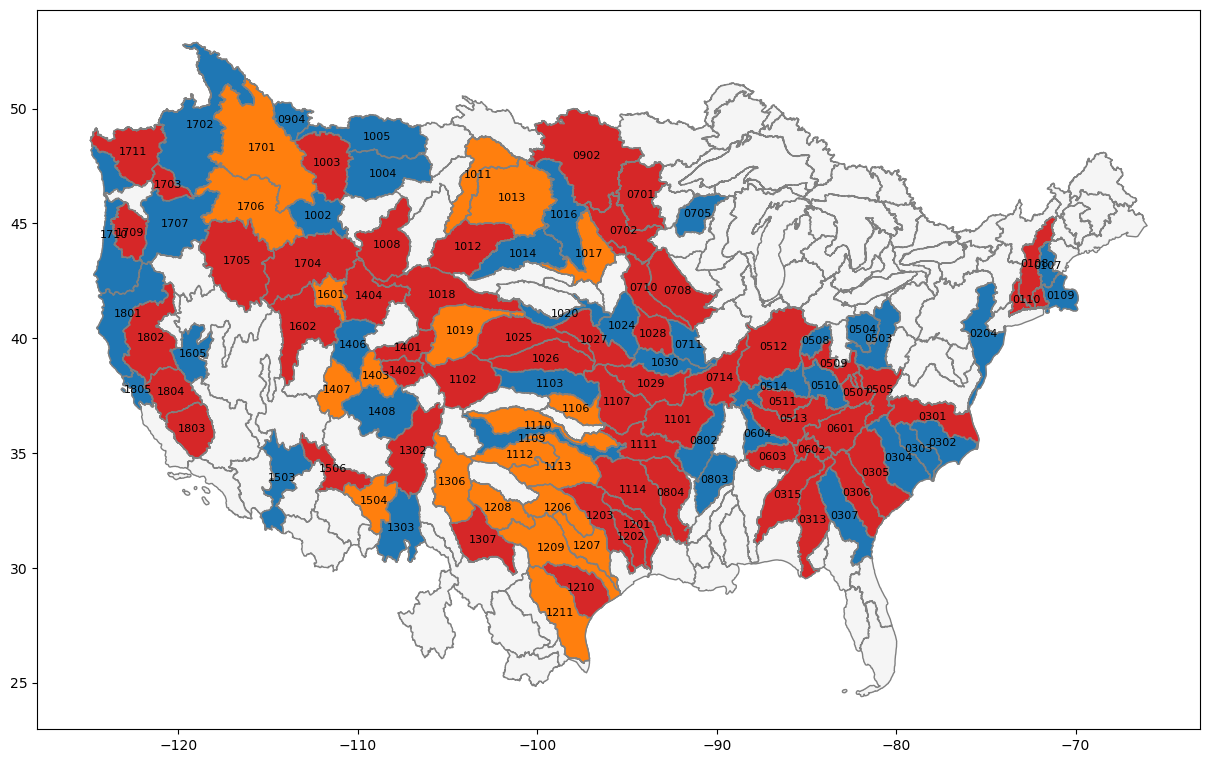

In [ ]:
df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx', dtype={'huc4':str})

huc4_gdrom_list = df_res_meta['huc4'].unique()
huc4_highlight_list = ['0108', '0110', '0305', '0306', '0313', '0315', '0505', '0507', '0509', '0511', '0512', '0513', '0601', '0602', '0603', '0701', '0714', '0902', '0804', '1003', '1008', '1012', '1018', '1029', '1101', '1102', '1107', '1114', '1203', '1302', '1401', '1402', '1404', '1602', '1703', '1704', '1705', '1709', '1711', '1802', '1803', '1804']

# huc4_highlight_list = huc4_list

# Concat huc4 gdf of each huc2
gdf_huc4_conus = gpd.GeoDataFrame()
gdf_huc2_conus = gpd.GeoDataFrame()
for huc2 in huc2_conus:
    # read HUC2s
    gdb_file = f'{nhd_data_dir}/Raw/WBD/WBD_{huc2}_HU2_GDB.gdb'
    gdf_huc4_in_huc2 = gpd.read_file(gdb_file, layer='WBDHU4')
    gdf_huc2 = gpd.read_file(gdb_file, layer='WBDHU2')

    # add to the conus gdf
    gdf_huc4_conus = pd.concat([gdf_huc4_conus, gdf_huc4_in_huc2], ignore_index=True)
    gdf_huc2_conus = pd.concat([gdf_huc2_conus, gdf_huc2], ignore_index=True)


# Plot
fig, ax = plt.subplots(figsize=(15, 12))

# plot huc4 across conus
gdf_huc4_conus.plot(ax=ax, facecolor='whitesmoke', edgecolor='gray', linewidth=1)

# highlight GDROM-included basins (452 reservoirs)
gdf_huc4_conus.loc[gdf_huc4_conus['huc4'].isin(huc4_gdrom_list)].plot(ax=ax, facecolor='tab:blue', edgecolor='gray', linewidth=1)
# add annotation for the highlighted basins
for idx, row in gdf_huc4_conus.loc[gdf_huc4_conus['huc4'].isin(huc4_gdrom_list)].iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['huc4'], fontsize=8, ha='center', va='center')

# highlight the huc4 basins (selected for analysis)
# gdf_huc4_conus.loc[gdf_huc4_conus['huc4'].isin(huc4_highlight_list)].plot(ax=ax, facecolor='tab:red', edgecolor='gray', linewidth=1)
# gdf_huc4_conus.loc[(gdf_huc4_conus['huc4'].isin(huc4_highlight_list)) & (gdf_huc4_conus['huc4'].str.startswith('18'))].plot(ax=ax, facecolor='tab:blue', edgecolor='gray', linewidth=1)
# gdf_huc2_conus.loc[gdf_huc2_conus['huc2']=='18'].plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)
    
gdf_huc4_conus.loc[gdf_huc4_conus['huc4'].isin(huc4_good_list)].plot(ax=ax, facecolor='tab:red', edgecolor='gray', linewidth=1)
gdf_huc4_conus.loc[gdf_huc4_conus['huc4'].isin(huc4_bad_list)].plot(ax=ax, facecolor='tab:orange', edgecolor='gray', linewidth=1)

plt.show()


In [ ]:
df_res_meta['huc4'].unique()

array(['1711', '1703', '1707', '1709', '1710', '1801', '1802', '1605',
       '1804', '1805', '0904', '1005', '1003', '1701', '1004', '1702',
       '1008', '1705', '1002', '1704', '1018', '1404', '1601', '1602',
       '1406', '1401', '1019', '1402', '1403', '1408', '1407', '1803',
       '1302', '1503', '1506', '1504', '1303', '1011', '0701', '0902',
       '1016', '1013', '0702', '1012', '1014', '1017', '0708', '0710',
       '1020', '1028', '1025', '0711', '1026', '1024', '1027', '1030',
       '1107', '1029', '1102', '1103', '1101', '0802', '1106', '1110',
       '1111', '1109', '1112', '1306', '0804', '1113', '1114', '1203',
       '1206', '1201', '1208', '1202', '1207', '1307', '1209', '1210',
       '1211', '0512', '0504', '0204', '0508', '0503', '0509', '0714',
       '0505', '0507', '0510', '0514', '0511', '0513', '0604', '0301',
       '0601', '0304', '0302', '0305', '0303', '0602', '0603', '0315',
       '0306', '0313', '0803', '0307', '0107', '0108', '0110', '0109',
      